In [1]:
import pandas as pd;
import numpy as np;

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
my_year_month_fmt = mdates.DateFormatter('%m/%y')

import statsmodels.api as sm
import statsmodels.tsa.stattools as ts

import yfinance as yf

import seaborn

In [2]:
symbol_list = ['PEP', 'KO']
data = yf.download(
    symbol_list, 
    start='2010-01-01', 
    end='2021-12-23'
)['Adj Close']

[*********************100%***********************]  2 of 2 completed


In [3]:
data

,KO,PEP
Date,,
2010-01-04,18.793242,41.343437
2010-01-05,18.565903,41.843002
2010-01-06,18.559309,41.424435
2010-01-07,18.513180,41.161148
2010-01-08,18.170528,41.026127
...,...,...
2021-12-16,56.103783,165.066452
2021-12-17,55.223721,161.684784
2021-12-20,55.041973,162.760742


Text(0, 0.5, 'Price in $')

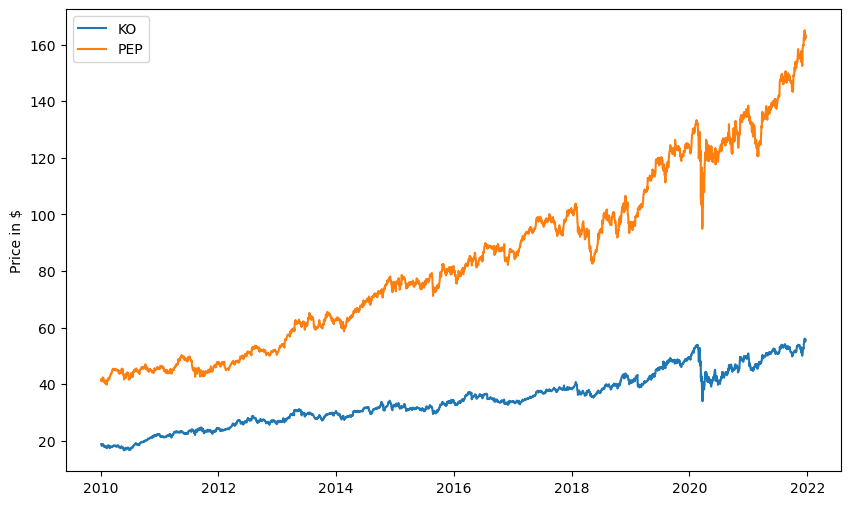

In [4]:
date_index = pd.to_datetime(data.index, format='%Y-%m-%d')
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(date_index, data['KO'], label='KO')
ax.plot(date_index, data['PEP'], label = 'PEP')

ax.legend(loc='best')
ax.set_ylabel('Price in $')

In [5]:
return_df = pd.DataFrame()
return_df['KO'] = (data['KO'] / data['KO'].shift(1)) - 1
return_df['PEP'] = (data['PEP'] / data['PEP'].shift(1)) - 1
return_df

,KO,PEP
Date,,
2010-01-04,NaN,NaN
2010-01-05,-0.012097,0.012083
2010-01-06,-0.000355,-0.010003
2010-01-07,-0.002486,-0.006356
2010-01-08,-0.018509,-0.003280
...,...,...
2021-12-16,0.010162,0.001457
2021-12-17,-0.015686,-0.020487
2021-12-20,-0.003291,0.006655


In [6]:
print('PEP KO Cointegration')
(ts.coint(data['PEP'], data['KO']))[1]

PEP KO Cointegration


0.033832768652981245

In [7]:
corr = data.corr(method = 'pearson')
print('PEP KO Correlation')
corr['KO']['PEP']

PEP KO Correlation


0.9764095599891257

Text(0.5, 1.0, 'PEPKO Spread')

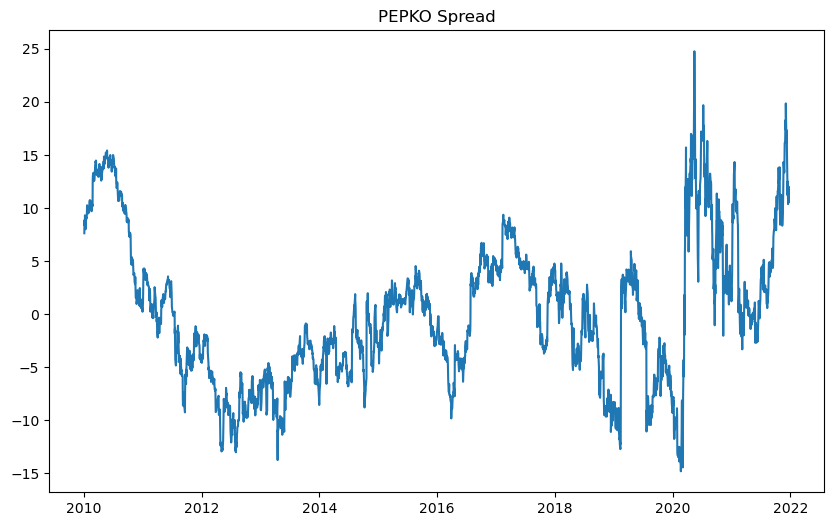

In [8]:
result = sm.OLS(data['PEP'],sm.add_constant(data['KO'])).fit()
data['PEPKOspread'] = (data['PEP'] - result.params[1]*data['KO']) -result.params[0]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(date_index, data['PEPKOspread'].values)
ax.set_title('PEPKO Spread')

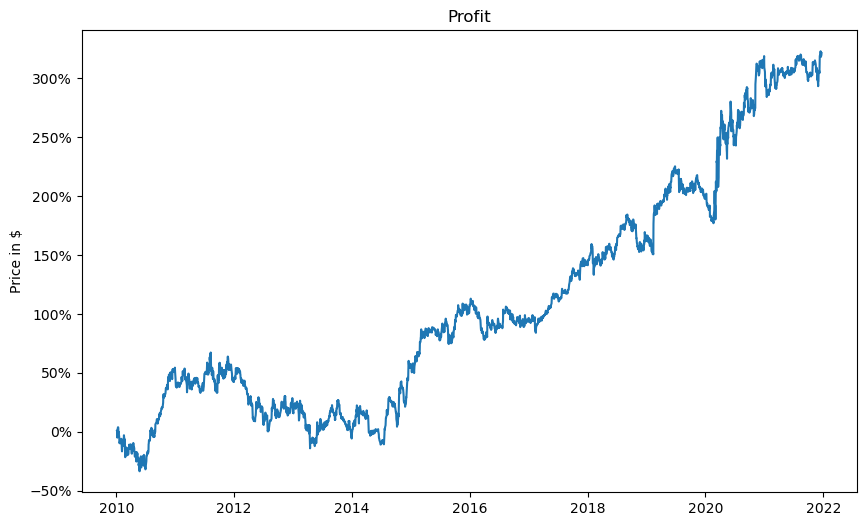

In [9]:
data['PEPKOposition'] = 0
data.loc[data['PEPKOspread']>0, 'PEPKOposition'] = -1
data.loc[data['PEPKOspread']<0, 'PEPKOposition'] = 1
data['PEPKOposition'] = data['PEPKOposition'].shift(1)
data['PEPposition'] = data['PEPKOposition']
data['KOposition'] = data['PEPKOposition']*result.params[1]*-1
data['dailypnl'] = data['KOposition']*return_df['KO'].shift(-1) + data['PEPposition']*return_df['PEP'].shift(-1)
data['cumpnl'] = data['dailypnl'].cumsum()

fig, ax = plt.subplots(figsize=(10,6))
ax.set_title('Profit')

ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
ax.set_ylabel('Price in $')

ax.plot(date_index,data['cumpnl'].values)
plt.show()
